In [1]:
%run data.py

# Traffic Collison Data

### NYC Open Data: Motor Vehicle Collisions (Filter data: 2019.9.1 to today)

In [2]:
collison_url = "https://data.cityofnewyork.us/resource/h9gi-nx95.csv?$select=crash_date,borough,zip_code,collision_id&$where=crash_date>'2019-09-01T00:00:00.000'&$limit=500000"
collison = pd.read_csv(collison_url)
collison.count()

crash_date      112953
borough          73589
zip_code         73571
collision_id    112953
dtype: int64

In [3]:
collison.head(10)

,crash_date,borough,zip_code,collision_id
0,2019-09-02T00:00:00.000,NaN,NaN,4198471
1,2019-09-02T00:00:00.000,NaN,NaN,4198682
2,2019-09-02T00:00:00.000,QUEENS,11355.0,4200132
3,2019-09-02T00:00:00.000,NaN,NaN,4200843
4,2019-09-02T00:00:00.000,NaN,NaN,4200529
5,2019-09-02T00:00:00.000,MANHATTAN,10032.0,4198436
6,2019-09-02T00:00:00.000,NaN,NaN,4199663
7,2019-09-02T00:00:00.000,NaN,NaN,4198487
8,2019-09-02T00:00:00.000,BROOKLYN,11234.0,4198947
9,2019-09-02T00:00:00.000,QUEENS,11422.0,4199165


In [4]:
collison['zip_code'].fillna(0, inplace=True)
collisonpd = collison.astype({"crash_date":'datetime64[ns]', "borough":str, "zip_code":int, "collision_id":int})

In [5]:
collison_df = spark.createDataFrame(collisonpd)

In [6]:
collison_df.createOrReplaceTempView("collisonT")
collison = spark.sql("""
SELECT MONTH(crash_date) AS month,
    COUNT(*) AS num_of_crash
FROM collisonT
GROUP BY month
ORDER BY month
""")

collison = collison.withColumn("month_name", 
                                        f.when(f.col('month') == 1, "2020-01")\
                                        .when(f.col('month') == 2, "2020-02")\
                                        .when(f.col('month') == 3, "2020-03")\
                                        .when(f.col('month') == 4, "2020-04")\
                                        .when(f.col('month') == 5, "2020-05")\
                                        .when(f.col('month') == 9, "2019-09")\
                                        .when(f.col('month') == 10, "2019-10")\
                                        .when(f.col('month') == 11, "2019-11")\
                                        .when(f.col('month') == 12, "2019-12"))

### Average number of crash before Covid-19

In [7]:
#Covid-19 started in March 2020
average = collison.filter('month !=3 and month !=4 and month !=5').agg({"num_of_crash":"avg"})




In [10]:
avg_num = average.rdd.map(list)
avg_num.take(6)

[[16104.833333333334]]

In [9]:
avg= avg_num.take(1)[0][0]
avg

16104.833333333334

In [11]:
print("Average number of car crashes before Covid-19: ", '%.2f' % avg)

Average number of car crashes before Covid-19:  16104.83


### Current month car crash number and falling rate

In [8]:
collison = collison.filter('month !=5')

In [9]:
collison.createOrReplaceTempView("latestT")
latest = spark.sql("SELECT num_of_crash FROM latestT WHERE month_name = \
                                     (SELECT max(month_name) FROM  latestT)")
latest = latest.rdd.map(list)
latest = latest.take(1)[0][0]
falling_rate = '%.2f' % ((avg - latest)/ avg*100)+"%"
#falling_rate = (avg - latest)/ avg
print("Current month number of car crashes: ",'%.2f' %latest)
print("Car carsh falling rate: ", falling_rate)
#falling_rate = falling_rate*100

Current month number of car crashes:  4043.00
Car carsh falling rate:  74.90%


In [10]:
collisonpd = collison.select("month_name","num_of_crash").orderBy("month_name").toPandas()
collisonpd

,month_name,num_of_crash
0,2019-09,17067
1,2019-10,17609
2,2019-11,16950
3,2019-12,17056
4,2020-01,14276
5,2020-02,13671
6,2020-03,11020
7,2020-04,4043


([0, 1, 2, 3, 4, 5, 6, 7], <a list of 8 Text xticklabel objects>)

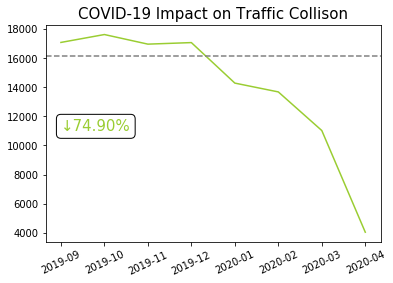

In [28]:
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.plot('month_name','num_of_crash', data=collisonpd, marker='', color='yellowgreen')
plt.title('COVID-19 Impact on Traffic Collison',fontsize = 15)

rate = "↓" + falling_rate
bbox_props = dict(boxstyle="round", facecolor = "white")
plt.text(0, 11000, rate, size = 15, color = "yellowgreen", bbox=bbox_props)

plt.axhline(y = avg,ls = "dashed",color = "grey") 

plt.xticks( rotation=25 )
#plt.rcParams['figure.figsize'] = (10,5)
#plt.legend()
#plt.savefig('/Users/jennyzhou/Downloads/traffic.png')

### Car crash vs Covid-19 cases (by borough)

Car crash by borough

In [12]:
collison_borough = spark.sql("""
SELECT borough,
    COUNT(*) AS num_of_crash
FROM collisonT
GROUP BY borough
ORDER BY num_of_crash desc
""")

In [13]:
from pyspark.sql.functions import col
df = collison_borough.withColumn("borough",
    f.when(collison_borough["borough"]=='nan','unknown').when(collison_borough["borough"]=='STATEN ISLAND','staten_island').
    otherwise(collison_borough["borough"]))
df=df.withColumn("borough",f.lower(f.col("borough")))
collison = df.toPandas()

Covid-19 cases by borough

In [14]:
cov = fetchData(nyc_his_boro_url)
cov = cov.drop(columns = ['timestamp','total'])
cov2 = cov.loc[cov['type']=='cases']
cov2 = cov2.tail(1)
cov2.set_index(["type"], inplace = True) 

cov2 = cov2.stack()
cov = cov2.unstack(0)
cov['borough']=cov.index

merge

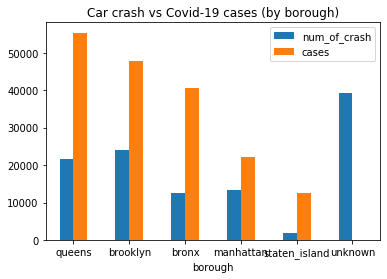

In [15]:
res = pd.merge(collison,cov, on='borough')
res = res.sort_values(by='cases',ascending=False)
res.set_index(["borough"], inplace = True) 
res.plot.bar(rot=0,title="Car crash vs Covid-19 cases (by borough)")

Collison since covid-19

In [16]:
collison_march= collison_df.filter(collison_df["crash_date"] >= to_timestamp(f.lit('2020-03-12 00:00:00')))

In [17]:
collison_march.createOrReplaceTempView("collisonT")
collison_covid = spark.sql("""
SELECT borough,
    COUNT(*) AS num_of_crash
FROM collisonT
GROUP BY borough

""")

In [18]:
from pyspark.sql.functions import col
cdf = collison_covid.withColumn("borough",
    f.when(collison_covid["borough"]=='nan','unknown').when(collison_covid["borough"]=='STATEN ISLAND','staten_island').
    otherwise(collison_covid["borough"]))
cdf=cdf.withColumn("borough",f.lower(f.col("borough")))
collison_covid = cdf.toPandas()

In [19]:
collison_covid.set_index(["borough"], inplace = True) 
collison_covid = collison_covid.reindex(['queens','brooklyn','bronx','manhattan','staten_island','unknown'])

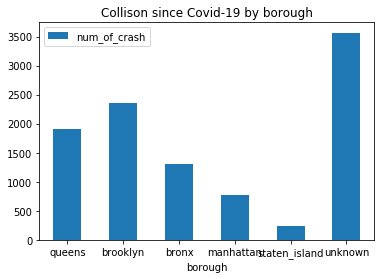

In [20]:
collison_covid.plot.bar(rot=0, title="Collison since Covid-19 by borough")

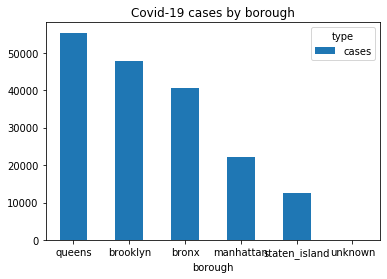

In [21]:
cov.set_index(["borough"], inplace = True) 
cov = cov.sort_values(by='cases',ascending=False)
cov.plot.bar(rot=0,title="Covid-19 cases by borough")

In [22]:
res2 = pd.merge(collison_covid,cov, on='borough')

In [23]:
res2.head(10)

,num_of_crash,cases
borough,,
queens,1918,55380
brooklyn,2364,47836
bronx,1312,40689
manhattan,780,22185
staten_island,232,12586
unknown,3566,90


In [24]:
res2 = res2.sort_values(by='cases',ascending=False)


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1240c4610>,
      dtype=object)

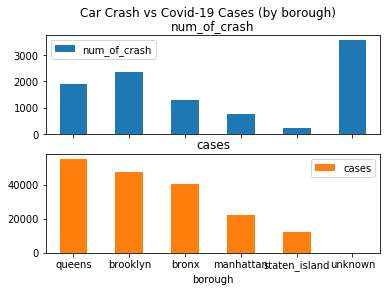

In [25]:
res2.plot.bar(rot=0,title="Car Crash vs Covid-19 Cases (by borough)", subplots = True)

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text xticklabel objects>)

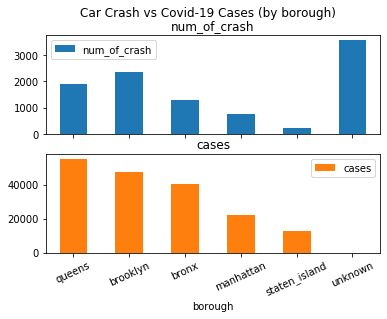

In [29]:
graph = res2.plot.bar(rot=0,title="Car Crash vs Covid-19 Cases (by borough)", subplots = True)
plt.xticks( rotation=25 )

In [27]:
graph[0].get_figure().savefig('/Users/jennyzhou/Downloads/traffic2.png')